In [16]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import GridSearchCV

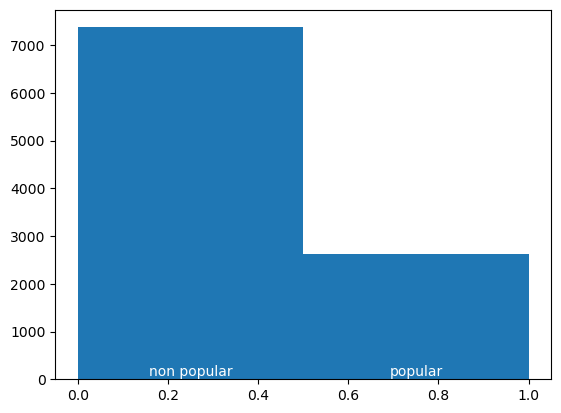

{'learning_rate': 0.1, 'max_bin': 500, 'max_depth': 16, 'n_estimators': 300, 'num_leaves': 500}
accuracy: 0.730909090909091


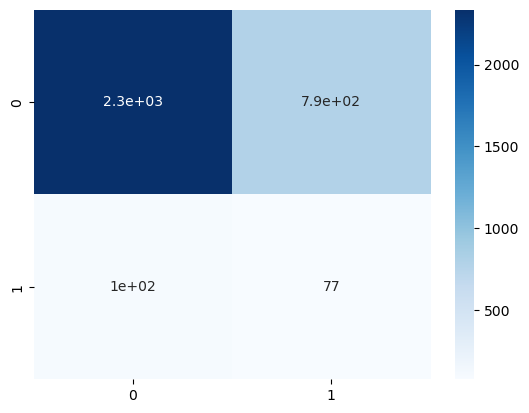

{}


In [22]:
#df=pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT8/master/data/yelp.csv')
df=pd.read_csv('yelp.csv',parse_dates=['date']).dropna()
df.drop(['business_id','type','review_id','user_id'],axis=1,inplace=True)
df.set_index('date',inplace=True)

df["popular"] = df.apply(lambda x: 1 if (x["stars"] >=3 and (x["funny"] >2 or x["cool"] >1 or x["useful"] > 1)) else 0, axis=1)
#print(df.head())

data=df["text"]
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data)
tokenizer.fit_on_texts(data)

X=tokenizer.texts_to_sequences(data)
max_length = df["text"].str.len().max()

#print(max_length)

X=pad_sequences(X,maxlen=max_length)
target=df["popular"]
y=np.array(target)

#Print a histogram
plt.hist(y, bins=2)
plt.annotate('popular', xy=(0.75, 2), xytext=(0.75, 2.5), ha='center', va='bottom', color='white')
plt.annotate('non popular', xy=(0.25, 2), xytext=(0.25, 2.5), ha='center', va='bottom', color='white')
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {
    'max_depth': [7, 10, 15, 16],
    'num_leaves': [8, 16, 32, 500],
    'learning_rate': [.1, .2, .3, .4],
    'n_estimators': [50,60,100,200, 300, 500],
    'max_bin':[100,200,400,500],
}

params = { 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'AUC', 'num_leaves': 8, 'max_depth':
          20, 'learning_rate': 0.001, }


scores=dict()
lgb_clf = LGBMClassifier(objective='binary',
        boosting_type='gbdt',
        #max_depth=max_depth[i],
        #num_leaves=num_leaves[i],
        #learning_rate=learning_rate[i],
        metric='binary_logloss',
        num_class=1,
        n_jobs=1,
        #n_estimators =n_estimators[i]
        )

grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print("accuracy:" ,accuracy_score(y_pred, y_test))
cm=confusion_matrix(y_pred, y_test)
sns.heatmap(cm,annot=True,cmap=plt.cm.Blues)
plt.show()
    
print(scores)    
